In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import seaborn as sns
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl
from tqdm.notebook import tqdm
np.random.seed(123)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read csv and parse date-times into Pandas Timestamp object
X_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_project/ratings.csv', parse_dates=['timestamp'])

In [ ]:
# we have approximately 26 million of rating data
X_data.shape

(26024289, 4)

# Preprocessing

In [ ]:
# count unique user ids, there are 270896 of them
user_counts = X_data['userId'].value_counts() 

We have a very huge amount of data (total of 26 million rows). We might want to get rid of those that do not give us a lot information. For example, let's see how many of the users have given less than only 20 ratings in total

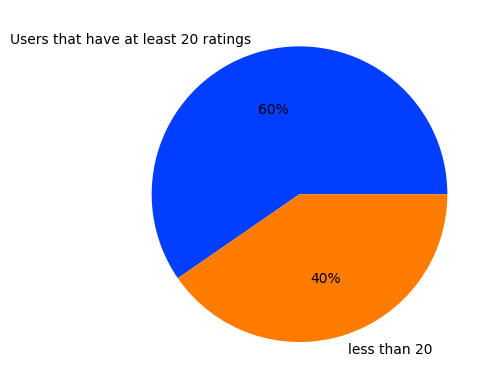

In [ ]:
# let's see the percentage of those in a pie chart
user_counts_py = user_counts.values
count_bigger = np.count_nonzero(user_counts_py > 20)
count_smaller = len(user_counts_py) - count_bigger
ls = []
ls.append(count_bigger)
ls.append(count_smaller)

palette_color = sns.color_palette('bright')
plt.pie(ls, labels=['Users that have at least 20 ratings', 'less than 20'], colors=palette_color, autopct='%.0f%%')
plt.show()

Get rid of the users that gave more than 20 ratings in total. By doing this, we


*   decrease the training time
*   reduce memory requirements
*   reduce noise

In return, we may lose some information. But even without those users we still have 161497 unique users





In [ ]:
# ids of users with > 20 occurences i.e. > 20 ratings, there are 161497 of them
user_ids = user_counts[user_counts > 20].index.tolist() 
# create a new dataframe to use in the future and keep the original one unchanged
# this new dataframe only has the users that gave more than 20 ratings
new_X_data = pd.DataFrame({'userId': user_ids, 'count': user_counts[user_counts > 20]})
print(new_X_data.shape)

(161497, 2)


Among the data that we now have at our hands, we will randomly choose %5 of them. This again comes with advantages and disadvantages, but in the end we will be left with around 8000 unique users and a total of over than 1.2 millions of data, which we think is a still significant amount of data


In [ ]:
np.random.seed(123) # necessary for consistent results
# randomly select % 5 of the users to simplify our data
rand_userIds = np.random.choice(new_X_data['userId'].unique(), size=int(len(new_X_data['userId'].unique())*0.05),replace=False)
# only get the rows of the selected users from the original data,
# i.e. combine the selected user ids with the rest of the information: movieId, rating, timestamp
new_X_data = X_data.loc[X_data['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(new_X_data), len(rand_userIds)))
print(new_X_data.shape)

There are 1250005 rows of data from 8074 users
(1250005, 4)


In [ ]:
# let's see our new data
new_X_data.head()

,userId,movieId,rating,timestamp
204,8,1,4.0,1013443596
205,8,7,2.0,1013442976
206,8,44,3.0,1013442518
207,8,47,4.0,1013443770
208,8,170,3.0,1013442544


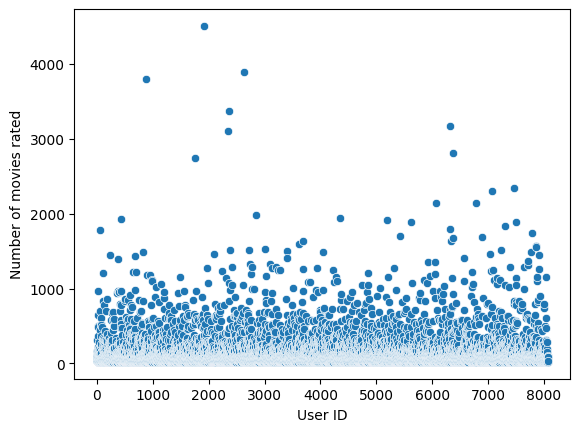

In [ ]:
# let's plot the ratings given by the users to have a general idea of the image
# we will see that vast majority of users gave less than ~700 ratings in total
movie_counts = new_X_data['userId'].value_counts(sort=False)
my_array = np.arange(len(rand_userIds))
zort_df = pd.DataFrame({'User ID': my_array,
                       'Number of movies rated': movie_counts})
sns.scatterplot(data=zort_df, x="User ID", y="Number of movies rated")
plt.show()

# Train - Validation - Test split

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

The most recent review for each user will serve as the test set (i.e., one is left out), the second most recent will serve as the validation set, and the remaining ratings will serve as training set

In [ ]:
# rank the timestamps of ratings for each user, put them in a new column 'rank_latest'
# most recent review of that user will have the highest ranking, least recent will have the lowest
new_X_data['rank_latest'] = new_X_data.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

In [ ]:
# let's see first 3 rows as an example
new_X_data.head(3)

,userId,movieId,rating,timestamp,rank_latest
204,8,1,4.0,1013443596,46.0
205,8,7,2.0,1013442976,72.0
206,8,44,3.0,1013442518,105.0


In [ ]:
unique_movie_ids = list(set(new_X_data['movieId']))  # Get unique movie IDs
unique_movie_ids.sort()  # Sort the unique IDs in ascending order
movie_id_mapping = {id: i+1 for i, id in enumerate(unique_movie_ids)}
new_X_data['movieId'] = [movie_id_mapping[id] for id in new_X_data['movieId']]

unique_user_ids = list(set(new_X_data['userId']))  # Get unique movie IDs
unique_user_ids.sort()  # Sort the unique IDs in ascending order
user_id_mapping = {id: i+1 for i, id in enumerate(unique_user_ids)}
new_X_data['userId'] = [user_id_mapping[id] for id in new_X_data['userId']]

test_ratings = new_X_data[new_X_data['rank_latest'] == 1]
valid_ratings = new_X_data[new_X_data['rank_latest'] == 2]
train_ratings = new_X_data[new_X_data['rank_latest'] > 2]

In [ ]:
print(train_ratings.shape) # around 1.2 mil data used for training
print(valid_ratings.shape) # around 8000 data used for valdiation
print(test_ratings.shape) # arounda 8000 data used for test
# these may change later

(1233857, 5)
(8074, 5)
(8074, 5)


In [ ]:
# drop 'rank_latest' column
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
valid_ratings = valid_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

In [ ]:
# save them into csv files
train_ratings.to_csv('new_train_ratings.csv', index=False)
valid_ratings.to_csv('new_valid_ratings.csv', index=False)
test_ratings.to_csv('new_test_ratings.csv', index=False)

In [ ]:
# see train data for example
train_ratings.head(5)

,userId,movieId,rating
204,8,1,4.0
205,8,7,2.0
206,8,44,3.0
207,8,47,4.0
208,8,170,3.0


# Convert Rating Information into an Implicit Feedback

The rating information we currently have can be considered as an Explicit Feedback, since ratings are quantiative numbers between 0 and 5. We will instead use Implicit Feedback. 

Therefore, our aim will not be to predict what rating a user would give to a particular movie. Instead, we will try to predict whether a user would user interact (watch) a movie that is recommended to her/him.

We will convert our training data to implicit feedback. Every instance in our data will have a label 1, since rating a movie indicates interaction. For every interaction, we will add 4 negative samples among the movies that the user has not interacted

(we may treat the negative sample value (4 in this case) as a hyperparameter, and change its value according to our validation results in the future)

This operation is done in get_dataset() method below

# PyTorch Dataset

We will use a PyTorch Dataset in order to be able to benefit the PyTorch Lightning library, as many methods of Trainer class of Lightning work in parallel with PyTorch Datasets, such as train_dataloader()

In [ ]:
import torch
from torch.utils.data import Dataset

class RatingDataset(Dataset):

    # ratings: ratings data (train_ratings for training)
    # all_movie_IDs: all unique movieIDs
    def __init__(self, ratings, all_movie_IDs):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movie_IDs)

    # get length
    def __len__(self):
        return len(self.users)
  
    # get single instance
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        # users: userIDs
        # items: movieIDs
        # labels: 0 or 1 : 'not interacted' or 'interacted'
        users = []
        items = []
        labels = []

        # tuple for user-item, to be able to iterate over (u, i)
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        # 4 negative samples for each positive sample
        neg_ratio = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1) # if it is in user_item_set, user already interacted with it
            for _ in range(neg_ratio):
                # randomly select an unwatched movie for that user
                negative_item = np.random.choice(all_movieIds)
                # keep selecting until it is certainly not watched by that user
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0) # add 0, because the user has not watched that movie

        # convert lists to PyTorch tensors
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

# NCF Model

\Let's define our Neural Collaborative Filtering model by using Lightning

## Model With Lightning


In [ ]:
best_losses = []

In [ ]:
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class ModelWithLightning(pl.LightningModule):

    # num_users: total number of unique users
    # num_items: total number of unique movies
    # ratings: rating data (train_ratings for training)
    # all_movieIds: all unique movie ids in all data    
    # embd_dimension: embedding dimension
    def __init__(self, num_users, num_items, ratings, all_movie_IDs, embd_dimension, layers, lr, batch):
        super().__init__()
        # init embedding layers
        self.layers = layers
        self.lr = lr
        self.batch_size = batch
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=embd_dimension)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=embd_dimension)
        # init fully connected and output layer
        if layers == 2: 
            self.dense1 = nn.Linear(in_features=16, out_features=64)
            self.dense2 = nn.Linear(in_features=64, out_features=32)
            # init output layer
            self.output = nn.Linear(in_features=32, out_features=1)
        elif layers == 3:
            self.dense1 = nn.Linear(in_features=16, out_features=64)
            self.dense2 = nn.Linear(in_features=64, out_features=32)
            self.dense3 = nn.Linear(in_features=32, out_features=16)
            # init output layer
            self.output = nn.Linear(in_features=16, out_features=1)
        self.ratings = ratings
        self.all_movie_IDs = all_movie_IDs
        self.training_step_outputs = []


    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers (results in 16 dim tensor)
        tensor = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer : feed forward 3 dense layers with ReLU activation
        tensor = nn.ReLU()(self.dense1(tensor))
        tensor = nn.ReLU()(self.dense2(tensor))
        if self.layers == 3:
            tensor = nn.ReLU()(self.dense3(tensor))

        # Output layer : uses Sigmoid activation
        pred = nn.Sigmoid()(self.output(tensor))

        return pred
    
    # forward propogation
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        # use Binary Cross Entropy loss (log-loss) to calculate the loss
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        self.training_step_outputs.append(loss)
        return loss

    # backpropogation
    def configure_optimizers(self):
        # use Adam Optimizer (SGD) to update weights
        return torch.optim.Adam(self.parameters(), lr = self.lr)
    
    def on_train_epoch_end(self):
        all_preds = torch.stack(self.training_step_outputs)
        avg_loss = all_preds.mean()
        self.log('avg_train_loss', avg_loss)  # Log the average loss for the epoch
        best_losses.append(avg_loss.item())
        print(f"Epoch: {self.current_epoch+1}/{self.trainer.max_epochs}, Loss: {avg_loss.item()}")

    def train_dataloader(self):
        return DataLoader(RatingDataset(self.ratings, self.all_movie_IDs),
                          batch_size=self.batch_size, num_workers=4)


# Train Our NCF Model

## Train the model using Lightning

In [ ]:
num_users = new_X_data['userId'].max()+1
num_items = new_X_data['movieId'].max()+1
all_movie_IDs = new_X_data['movieId'].unique()
embd_dimension = 8

# Hyperparameters to be tuned
hyperparams = {
    "layers" : [2, 3],
    "batch_sizes" : [256, 512],
    "alphas" : [0.001, 0.01, 0.1]
}

# Model With Lightning

all_models = []
for layer in hyperparams["layers"]:
    for batch_size in hyperparams["batch_sizes"]:
        for alpha in hyperparams["alphas"]:
            print(f"Model with layers: {'[16, 64]' if layer == 2 else '[16, 64, 32]'}, batch_size: {batch_size}, lr: {alpha}")
            model_lightning = ModelWithLightning(num_users, num_items, train_ratings, all_movie_IDs, embd_dimension, layer, alpha, batch_size)
            trainer = pl.Trainer(max_epochs=7, logger=False)
            trainer.fit(model_lightning)
            all_models.append(model_lightning)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model with layers: [16, 64], batch_size: 256, lr: 0.001


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params siz

Model with layers: [16, 64], batch_size: 256, lr: 0.01


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params siz

Model with layers: [16, 64], batch_size: 256, lr: 0.1


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params siz

Model with layers: [16, 64], batch_size: 512, lr: 0.001


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params siz

Model with layers: [16, 64], batch_size: 512, lr: 0.01


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.320    Total estimated model params siz

Model with layers: [16, 64], batch_size: 512, lr: 0.1


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14

Model with layers: [16, 64, 32], batch_size: 256, lr: 0.001


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14

Model with layers: [16, 64, 32], batch_size: 256, lr: 0.01


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14

Model with layers: [16, 64, 32], batch_size: 256, lr: 0.1


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14

Model with layers: [16, 64, 32], batch_size: 512, lr: 0.001


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14

Model with layers: [16, 64, 32], batch_size: 512, lr: 0.01


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 2.2 M 
1 | item_embedding | Embedding | 1.4 M 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | dense3         | Linear    | 528   
5 | output         | Linear    | 17    
---------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14

Model with layers: [16, 64, 32], batch_size: 512, lr: 0.1


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


We will use **Hit Ratio @ 10**

It is an evaluation metric commonly used in recommender systems to measure the ability of a model to recommend relevant items to a user. It is defined as the percentage of cases where at least one of the top 10 recommended items matches a held-out test item that the user actually interacted with. In other words, if a user has interacted with any of the top 10 recommended items, the recommendation is considered a "hit."

*   For each user, randomly select 99 movies that the user has not interacted with
*   Combine these 99 items with the test item (the actual item that the user last interacted with). We now have 100 items
*   Run the model on these 100 items, and rank them according to their predicted probabilities
*   Select the top 10 items from the list of 100 items. If the test item is present within the top 10 items, then we say that this is a hit
*   Repeat the process for all users. The Hit Ratio is then the average hits

In [ ]:
def evaluate(model):

    # tuple of users-items (valid_ratings for now, later will be tested with test_ratings)
    test_set = set(zip(valid_ratings['userId'], valid_ratings['movieId']))

    # dictionary of all items that are interacted by each user
    user_interacted_items = new_X_data.groupby('userId')['movieId'].apply(list).to_dict()

    hits = []
    for (user, item) in test_set:
        watched_items = user_interacted_items[user] # movies that are watched by that user
        all_not_watched_items = set(all_movie_IDs) - set(watched_items) # movies that are not watched by that user
        random_not_watched_items = list(np.random.choice(list(all_not_watched_items), 99)) # randomly choose 99 unwatched
        test_items = random_not_watched_items + [item] # total of 100 items
        # get prediction for each item for that user
        predicted_labels = np.squeeze(model(torch.tensor([user]*100), torch.tensor(test_items)).detach().numpy())
        
        # choose top 10. These 10 movies will be recommended to the user
        top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
        
        if item in top10_items:
            hits.append(1) # hit
        else:
            hits.append(0) # miss
            
    print("The Hit Ratio @ 10 is {:.6f}".format(np.average(hits))) # get the average
    return np.average(hits)

In [ ]:
alpha_idx = -1
history = []
for i, model in enumerate(all_models):
    alpha_idx += 1
    print(f"Model with layers: {'[16, 64]' if i < 6 else '[16, 64, 32]'}, ", end="")
    print(f"batch_size: {hyperparams['batch_sizes'][0 if i < 3 or (i >= 6 and i <= 8) else 1]}, ", end="")
    print(f"learning_rate: {hyperparams['alphas'][alpha_idx]}: ", end="")
    if (i+1) % 3 == 0: alpha_idx = -1
    history.append(evaluate(model))

Model with layers: [16, 64], batch_size: 256, learning_rate: 0.001: The Hit Ratio @ 10 is 0.860788
Model with layers: [16, 64], batch_size: 256, learning_rate: 0.01: The Hit Ratio @ 10 is 0.548179
Model with layers: [16, 64], batch_size: 256, learning_rate: 0.1: The Hit Ratio @ 10 is 1.000000
Model with layers: [16, 64], batch_size: 512, learning_rate: 0.001: The Hit Ratio @ 10 is 0.810131
Model with layers: [16, 64], batch_size: 512, learning_rate: 0.01: The Hit Ratio @ 10 is 0.886178
Model with layers: [16, 64], batch_size: 512, learning_rate: 0.1: The Hit Ratio @ 10 is 0.816324
Model with layers: [16, 64, 32], batch_size: 256, learning_rate: 0.001: The Hit Ratio @ 10 is 0.854100
Model with layers: [16, 64, 32], batch_size: 256, learning_rate: 0.01: The Hit Ratio @ 10 is 0.878870
Model with layers: [16, 64, 32], batch_size: 256, learning_rate: 0.1: The Hit Ratio @ 10 is 0.759475
Model with layers: [16, 64, 32], batch_size: 512, learning_rate: 0.001: The Hit Ratio @ 10 is 0.833044
Mod

Evaluate

# Train the best model on train + validation data, and test it on test data fo final results


In [ ]:
# Best Model: 
# Model with layers: [16, 64], batch_size: 256, learning_rate: 0.01

In [ ]:
new_train_ratings = pd.concat([train_ratings, valid_ratings])

In [ ]:
num_users = new_X_data['userId'].max()+1
num_items = new_X_data['movieId'].max()+1
all_movie_IDs = new_X_data['movieId'].unique()
embd_dimension = 8

In [ ]:
layer = 2
alpha = 0.01
batch_size = 512
num_epochs = 7
best_model = ModelWithLightning(num_users, num_items, new_train_ratings, all_movie_IDs, embd_dimension, layer, alpha, batch_size)
trainer = pl.Trainer(max_epochs=num_epochs, logger=False)
trainer.fit(best_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 64.6 K
1 | item_embedding | Embedding | 167 K 
2 | dense1         | Linear    | 1.1 K 
3 | dense2         | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
234 K     Trainable params
0         Non-trainable params
234 K     Total params
0.939     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch: 1/7, Loss: 0.24809543788433075
Epoch: 2/7, Loss: 0.22767867147922516
Epoch: 3/7, Loss: 0.21674084663391113
Epoch: 4/7, Loss: 0.20985819399356842
Epoch: 5/7, Loss: 0.20466941595077515
Epoch: 6/7, Loss: 0.20037582516670227


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch: 7/7, Loss: 0.19684746861457825


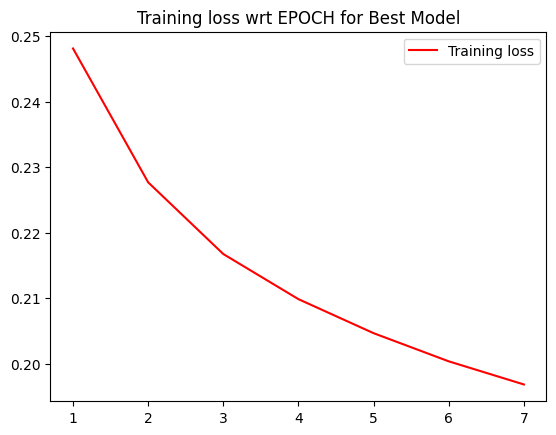

<Figure size 640x480 with 0 Axes>

In [ ]:
# TEST : loss vs epoch
numbers = []
for i in range(1, num_epochs+1):
    numbers.append(i)

plt.plot(numbers, best_losses, 'r', label='Training loss')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training loss wrt EPOCH for Best Model')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# 10 hit ratio on test_ratings

In [ ]:
def evaluate(model):

    # tuple of users-items (using TEST data)
    test_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

    # dictionary of all items that are interacted by each user
    user_interacted_items = new_X_data.groupby('userId')['movieId'].apply(list).to_dict()

    hits = []
    for (user, item) in test_set:
        watched_items = user_interacted_items[user] # movies that are watched by that user
        all_not_watched_items = set(all_movie_IDs) - set(watched_items) # movies that are not watched by that user
        random_not_watched_items = list(np.random.choice(list(all_not_watched_items), 99)) # randomly choose 99 unwatched
        test_items = random_not_watched_items + [item] # total of 100 items
        # get prediction for each item for that user
        predicted_labels = np.squeeze(model(torch.tensor([user]*100), torch.tensor(test_items)).detach().numpy())
        
        # choose top 10. These 10 movies will be recommended to the user
        top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
        
        if item in top10_items:
            hits.append(1) # hit
        else:
            hits.append(0) # miss
            
    print("The Hit Ratio @ 10 is {:.6f}".format(np.average(hits))) # get the average
    return np.average(hits)

In [ ]:
print("10 Hit Ratio for the best model on test data: ", end="")
final_hit_ratio = evaluate(best_model)

10 Hit Ratio for the best model on test data: The Hit Ratio @ 10 is 0.869086


In [ ]:
#t-SNE

Fast t-SNE implementation Installation


In [ ]:
user_embeddings = model.user_embedding.weight.data.cpu().numpy()
item_embeddings = model.item_embedding.weight.data.cpu().numpy()

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install pyarrow==10.0.0

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from cuml.manifold import TSNE

In [ ]:
num_users = 8075
# Combine user and item embeddings into a single matrix
combined_embeddings = np.concatenate((user_embeddings, item_embeddings), axis=0)

# Apply t-SNE to obtain lower-dimensional representations
tsne = TSNE(n_components = 2, random_state = 42, n_iter=10000, perplexity=80 ,n_neighbors=240)
embeddings_2d = tsne.fit_transform(combined_embeddings)

# Separate user and item embeddings
user_embeddings_2d = embeddings_2d[:num_users]
item_embeddings_2d = embeddings_2d[num_users:]

In [ ]:
# Plot the embeddings
plt.figure(figsize=(15, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], label='Concatenated Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Concatenated Embeddings t-SNE')
plt.legend()
plt.show()

In [ ]:
# Apply t-SNE to obtain lower-dimensional representations
tsne = TSNE(n_components = 2, random_state = 42, n_iter=325)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

tsne2 = TSNE(n_components = 2, random_state = 42, n_iter=325)
item_embeddings_2d = tsne2.fit_transform(item_embeddings)

In [ ]:
plt.figure(figsize=(20, 30))
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], label='Item Embeddings', color='orange', alpha=0.60)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Item Embeddings Visualization')
plt.legend()
plt.show()